In [1]:
import cryptocompare
coin = cryptocompare.get_coin_list(format=False)

#list the currencies you wish to analyze here
coin_top10 = ['Bitcoin', 'Ethereum ', 'Bitcoin Cash / BCC', 'Ripple', 'Litecoin', 'NEM', 'DigitalCash', 'ZCash','Monero', 'IOTA', 'Ethereum Classic', 'Nxt', 'Stellar']
coin_top10_sym = []
for key, value in coin.items():
    if value['CoinName'] in coin_top10:
        print(key, value['CoinName'])
        coin_top10_sym.append(key)

NXT Nxt
LTC Litecoin
ZEC ZCash
BTC Bitcoin
XLM Stellar
MIOTA IOTA
XMR Monero
XEM NEM
ETC Ethereum Classic


In [2]:
import pandas as pd
import requests
from pandas import json_normalize

#determine how many rows of data here
lim = '2000'

df = pd.DataFrame()
for i in coin_top10_sym:
    URL = 'https://min-api.cryptocompare.com/data/histohour?fsym='+i+'&tsym=USD&limit='+lim
    data = requests.get(URL)
    json_data = data.json()
    table = json_normalize(json_data, 'Data').set_index('time')
    table.index = pd.to_datetime(table.index ,unit='s')
    df = pd.concat([df, table.high], axis=1)
df.columns = coin_top10_sym

In [3]:
# Performing Dickey-Fuller stationary test

from statsmodels.tsa.stattools import adfuller

for i in df.columns: 
    x = df[i].values
    result = adfuller(x)
    print('\033[1m' + i + '\033[0m')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])

NXT
ADF Statistic: -5.343696656851099
p-value: 4.442660594405529e-06
LTC
ADF Statistic: -2.4494877598557117
p-value: 0.1282530059795287
ZEC
ADF Statistic: -0.44337967930976513
p-value: 0.9026001055872799
BTC
ADF Statistic: -2.9001160539362107
p-value: 0.04533450364281703
XLM
ADF Statistic: -2.3332736696110876
p-value: 0.16146096050884257
MIOTA
ADF Statistic: -3.1098093236249413
p-value: 0.025835720105225946
XMR
ADF Statistic: -2.4172478678347913
p-value: 0.1369273828190109
XEM
ADF Statistic: -2.910379396509811
p-value: 0.044154259819647046
ETC
ADF Statistic: -0.49773097374198194
p-value: 0.8924585218065995


In [4]:
# Perform differencing to stationalize the series

# Creat difference function, with default value of lag 1
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

# Differencing the dataset 
df_diff = pd.DataFrame()
for i in df.columns:
    df_diff[i] = difference(df[i])

In [5]:
for i in df.columns: 
    x = df_diff[i].values
    result = adfuller(x)
    print('\033[1m' + i + '\033[0m')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])

NXT
ADF Statistic: -13.834515550221585
p-value: 7.486037050248051e-26
LTC
ADF Statistic: -20.862385394422084
p-value: 0.0
ZEC
ADF Statistic: -41.14689658929888
p-value: 0.0
BTC
ADF Statistic: -40.20514666932366
p-value: 0.0
XLM
ADF Statistic: -11.356593012226561
p-value: 9.700584198457507e-21
MIOTA
ADF Statistic: -21.64964127170656
p-value: 0.0
XMR
ADF Statistic: -21.290737540398528
p-value: 0.0
XEM
ADF Statistic: -35.44162280210475
p-value: 0.0
ETC
ADF Statistic: -9.364197584498731
p-value: 7.678367547573548e-16


In [6]:
from itertools import permutations
com = list(permutations(coin_top10_sym, 2))
pair_list = []
count = 0
for i in com:
    globals()[str(i[0]) + '_' + str(i[1])] = df_diff[[com[count][0], com[count][1]]]
    count = count + 1
    pair_list.append(str(i[0]) + '_' + str(i[1]))

In [7]:
# Performing Granger Causality Test

import statsmodels.tsa.stattools as sm
lag = 24
cor = {}
for i in pair_list:
    cor[i] = sm.grangercausalitytests(eval(i), lag)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2451  , p=0.6206  , df_denom=1996, df_num=1
ssr based chi2 test:   chi2=0.2454  , p=0.6203  , df=1
likelihood ratio test: chi2=0.2454  , p=0.6203  , df=1
parameter F test:         F=0.2451  , p=0.6206  , df_denom=1996, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1679  , p=0.8455  , df_denom=1993, df_num=2
ssr based chi2 test:   chi2=0.3366  , p=0.8451  , df=2
likelihood ratio test: chi2=0.3366  , p=0.8451  , df=2
parameter F test:         F=0.1679  , p=0.8455  , df_denom=1993, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2381  , p=0.8698  , df_denom=1990, df_num=3
ssr based chi2 test:   chi2=0.7168  , p=0.8692  , df=3
likelihood ratio test: chi2=0.7167  , p=0.8693  , df=3
parameter F test:         F=0.2381  , p=0.8698  , df_denom=1990, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.2845  , p=0.

In [8]:
for key, values in cor.items():
    print('\n')
    print('\033[1m' + key + '\033[0m')
    for i in range(1, lag+1):
        print('lag', i, '=', values[i][0]['lrtest'][1])



NXT_LTC
lag 1 = 0.6203267603130893
lag 2 = 0.8450946096486369
lag 3 = 0.8692676536875981
lag 4 = 0.8873871396347173
lag 5 = 0.869703243852229
lag 6 = 0.7775929093634093
lag 7 = 0.8559840259515747
lag 8 = 0.88353617261327
lag 9 = 0.8872943859101231
lag 10 = 0.7171144023243767
lag 11 = 0.7904420736460523
lag 12 = 0.839296196566122
lag 13 = 0.7667057929728359
lag 14 = 0.4395170694167478
lag 15 = 0.49455322091437703
lag 16 = 0.31585173849353937
lag 17 = 0.282499079696539
lag 18 = 0.17955094638669455
lag 19 = 0.22571932945930295
lag 20 = 0.26987208245599664
lag 21 = 0.3484770814106946
lag 22 = 0.3210164474971799
lag 23 = 0.37805471004105057
lag 24 = 0.4109180026482129


NXT_ZEC
lag 1 = 0.6455599523754517
lag 2 = 0.15686160103415894
lag 3 = 0.3528506049114481
lag 4 = 0.3523913321255034
lag 5 = 0.5291825353681003
lag 6 = 0.4598585447542949
lag 7 = 0.4389591313047614
lag 8 = 0.3299511516972276
lag 9 = 0.4084490381245086
lag 10 = 0.5106500298568902
lag 11 = 0.5094320128163947
lag 12 = 0.55456

In [9]:
# Printing top correlated coins results

# Manually going through the test results to identify pairs with lowest lag values
top = ['ETC_XMR', 'ETC_XEM', 'XEM_XMR', 'LTC_XMR', 'LTC_XEM', 'MIOTA_XMR', 'ZEC_XMR', 'BTC_XMR', 'BTC_XEM', 'XLM_XMR']
for key, values in cor.items():
    if key in top:
        print('\n')
        print('\033[1m' + key + '\033[0m')
        for i in range(1, lag+1):
            print('lag', i, '=', values[i][0]['lrtest'][1])



LTC_XMR
lag 1 = 4.5445062413201295e-37
lag 2 = 2.285459527180833e-36
lag 3 = 2.097405552354665e-35
lag 4 = 4.4287792278849706e-36
lag 5 = 1.9483464277633862e-35
lag 6 = 5.318297780474536e-35
lag 7 = 7.163321598079827e-35
lag 8 = 2.4318216892018173e-34
lag 9 = 6.432806154886536e-34
lag 10 = 2.5760004892088755e-33
lag 11 = 7.083079922370542e-33
lag 12 = 1.0184073323276401e-32
lag 13 = 5.6386231642709054e-33
lag 14 = 1.43083956065123e-32
lag 15 = 6.593211599523968e-33
lag 16 = 2.5397489383367855e-32
lag 17 = 6.052038394142395e-32
lag 18 = 9.018907009058988e-32
lag 19 = 4.359935283650813e-31
lag 20 = 5.733728792372117e-31
lag 21 = 1.0308576417017316e-30
lag 22 = 1.3979485239387291e-30
lag 23 = 3.316541905471613e-30
lag 24 = 6.485390971938896e-30


LTC_XEM
lag 1 = 1.5041429607690348e-32
lag 2 = 8.763791295229491e-32
lag 3 = 5.340098542165677e-31
lag 4 = 5.103317881248926e-30
lag 5 = 2.837404946257848e-29
lag 6 = 7.304872526760728e-29
lag 7 = 1.2728298781828148e-28
lag 8 = 5.69153395508993

No handles with labels found to put in legend.


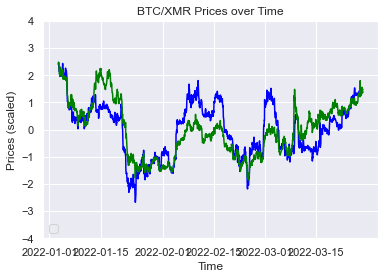

In [10]:
# Scaling and visualizing BTC_XMR

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
df_plot = pd.DataFrame(index=df.index)
df_plot['BTC'] = sc_x.fit_transform(df['BTC'].values.reshape(-1,1))
df_plot['XMR'] = sc_x.fit_transform(df['XMR'].values.reshape(-1,1))

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.plot(df.index, df_plot['BTC'], color='blue')
plt.plot(df.index, df_plot['XMR'], color='green')
plt.ylim((-4, 4))
plt.legend(loc='lower left')
plt.xlabel('Time')
plt.ylabel('Prices (scaled)')
plt.title('BTC/XMR Prices over Time')
plt.show()

In [11]:
import cryptocompare
import requests
import json
import pandas as pd
from pandas import json_normalize
import datetime
from pytrends.request import TrendReq
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader.data as web
import demjson
import eventregistry


# Login to Google
pytrend = TrendReq()
# Get today date
today_date = datetime.datetime.now().strftime('%Y-%m-%d')

In [12]:
# Getting price data of BTC and XMR using Cryptocompare API

# Indicate how many rows of data here
lim = '2000' 
pair = ['BTC', 'XMR']
coins = pd.DataFrame()
# Making API call, normalize JSON file, and put it in Dataframe
for i in pair:
    URL = 'https://min-api.cryptocompare.com/data/histohour?fsym='+i+'&tsym=USD&limit='+lim 
    data = requests.get(URL)
    json_data = data.json()
    table = json_normalize(json_data, 'Data').set_index('time') # Set index
    table.index = pd.to_datetime(table.index ,unit='s') # Make datetime object
    coins = pd.concat([coins, table.high], axis=1)
coins.columns = pair

from_date = coins.index[0].strftime('%Y-%m-%d') # Get date where the query started

In [13]:
# Importing market cap data already stored in csv file

mc = pd.read_csv('mc_coins.csv').set_index('date') # Set index
mc.index = pd.to_datetime(mc.index) # Make datetime object
mc = mc.resample('1h').pad() # Upsample from daily to hourly

In [14]:
# Query stock data from Yahoo! Financial using pandas_datareader

# Specify start and end time here
start = datetime.datetime(2022, 1, 4)
end = datetime.datetime(2022, 3, 24)

amd = web.DataReader('AMD', 'yahoo', start, end)
nvda = web.DataReader('NVDA', 'yahoo', start, end)

# Cleaning and resampling data
amd = amd.resample('1h').pad().drop(['Open', 'Low', 'Close', 'Adj Close', 'Volume'], axis='columns')
nvda = nvda.resample('1h').pad().drop(['Open', 'Low', 'Close', 'Adj Close', 'Volume'], axis='columns')
amd.columns = ['amd']
nvda.columns = ['nvda']

In [15]:
# Getting data from Google Trends using Pytrends API
 
# keyword = 'cryptocurrency', cathegory = 16 (news), timeframe- limit range to 8 months to get daily data
pytrend.build_payload(kw_list=['cryptocurrency'], cat=16, timeframe=from_date+' '+today_date) # Build payload
ggtrends_1 = pytrend.interest_over_time()
ggtrends_1 = ggtrends_1.resample('1h').pad().drop(['isPartial'], axis='columns') # Upsample daily to hourly
ggtrends_1.columns = ['gg_crypto']

# keyword = 'bitcoin price', cathegory = 0 (all), timeframe- limit range to 8 months to get daily data
pytrend.build_payload(kw_list=['bitcoin price'], cat=0, timeframe=from_date+' '+today_date)  
ggtrends_2 = pytrend.interest_over_time()
ggtrends_2 = ggtrends_2.resample('1h').pad().drop(['isPartial'], axis='columns')
ggtrends_2.columns = ['gg_bitcoin_p']

# keyword = 'monero price', cathegory = 0 (all), timeframe- limit range to 8 months to get daily data
pytrend.build_payload(kw_list=['monero price'], cat=0, timeframe=from_date+' '+today_date)  
ggtrends_3 = pytrend.interest_over_time()
ggtrends_3 = ggtrends_3.resample('1h').pad().drop(['isPartial'], axis='columns')
ggtrends_3.columns = ['gg_monero_p']

# keyword = 'bitcoin wallet', cathegory = 0 (all), timeframe- limit range to 8 months to get daily data
pytrend.build_payload(kw_list=['bitcoin wallet'], cat=0, timeframe=from_date+' '+today_date)  
ggtrends_4 = pytrend.interest_over_time()
ggtrends_4 = ggtrends_4.resample('1h').pad().drop(['isPartial'], axis='columns')
ggtrends_4.columns = ['gg_bitcoin_w']

# keyword = 'monero wallet', cathegory = 0 (all), timeframe- limit range to 8 months to get daily data
pytrend.build_payload(kw_list=['monero wallet'], cat=0, timeframe=from_date+' '+today_date)  
ggtrends_5 = pytrend.interest_over_time()
ggtrends_5 = ggtrends_5.resample('1h').pad().drop(['isPartial'], axis='columns')
ggtrends_5.columns = ['gg_monero_w']

# keyword = 'gpu mining', cathegory = 0 (all), timeframe- limit range to 8 months to get daily data
pytrend.build_payload(kw_list=['gpu mining'], cat=0, timeframe=from_date+' '+today_date)  
ggtrends_6 = pytrend.interest_over_time()
ggtrends_6 = ggtrends_6.resample('1h').pad().drop(['isPartial'], axis='columns')
ggtrends_6.columns = ['gg_gpu']

In [16]:
# Joining data frames
df = pd.concat([coins, amd, nvda, mc, ggtrends_1, ggtrends_2, ggtrends_3, ggtrends_4, ggtrends_5, ggtrends_6], axis=1).dropna(how='any')
df.to_csv('cap1_df.csv')

In [17]:
# Feature Scaling
df_scaled = df.copy(deep=True)

sc_x = StandardScaler()
df_scaled['BTC'] = sc_x.fit_transform(df_scaled['BTC'].values.reshape(-1,1))
df_scaled['XMR'] = sc_x.fit_transform(df_scaled['XMR'].values.reshape(-1,1))
df_scaled['mc_bitcoin'] = sc_x.fit_transform(df_scaled['mc_bitcoin'].values.reshape(-1,1))
df_scaled['mc_monero'] = sc_x.fit_transform(df_scaled['mc_monero'].values.reshape(-1,1))
df_scaled['gg_crypto'] = sc_x.fit_transform(df_scaled['gg_crypto'].values.reshape(-1,1))
df_scaled['gg_bitcoin_p'] = sc_x.fit_transform(df_scaled['gg_bitcoin_p'].values.reshape(-1,1))
df_scaled['gg_monero_p'] = sc_x.fit_transform(df_scaled['gg_monero_p'].values.reshape(-1,1))
df_scaled['gg_bitcoin_w'] = sc_x.fit_transform(df_scaled['gg_bitcoin_w'].values.reshape(-1,1))
df_scaled['gg_monero_w'] = sc_x.fit_transform(df_scaled['gg_monero_w'].values.reshape(-1,1))
df_scaled['gg_gpu'] = sc_x.fit_transform(df_scaled['gg_gpu'].values.reshape(-1,1))
df_scaled['amd'] = sc_x.fit_transform(df_scaled['amd'].values.reshape(-1,1))
df_scaled['nvda'] = sc_x.fit_transform(df_scaled['nvda'].values.reshape(-1,1))

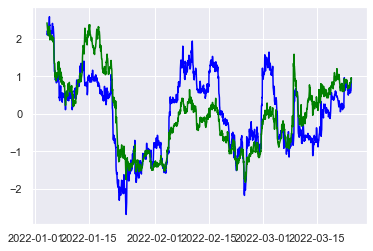

In [18]:
plt.plot(df_scaled.index, df_scaled['BTC'], color='blue')
plt.plot(df_scaled.index, df_scaled['XMR'], color='green')
plt.show()

In [19]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler

In [20]:
# Import dataframe 

df = pd.read_csv('cap1_df.csv', index_col=0)

In [21]:
# Standardize the data

sc_x = StandardScaler()
df_scaled = pd.DataFrame(sc_x.fit_transform(df), index=df.index, columns=df.columns)

In [22]:
# Perform differencing to stationalize the series

# Creat difference function, with default value of lag 24
def difference(dataset, interval=24):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

# Differencing the dataset
inter_d = 24
df_diff = pd.DataFrame(index=df.index)
for i in df.columns:
    data = difference(df_scaled[i], inter_d)
    data = pd.Series(np.append(np.repeat(np.nan, inter_d), data), index=df.index, name=i)
    df_diff = pd.concat([df_diff, data], ignore_index=False, axis=1)

In [23]:
# Perform Dickey-fuller test to test the differenced series for stationality

diff = df_diff.dropna()

for i in diff.columns: 
    x = diff[i].values
    result = adfuller(x)
    print('\033[1m' + i + '\033[0m')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])

BTC
ADF Statistic: -5.461106898134126
p-value: 2.517494726460463e-06
XMR
ADF Statistic: -5.401438140084181
p-value: 3.363724921966369e-06
amd
ADF Statistic: -5.052162385851412
p-value: 1.748031487879633e-05
nvda
ADF Statistic: -5.350528794962628
p-value: 4.299293693298112e-06
mc_bitcoin
ADF Statistic: -5.261962062747371
p-value: 6.561671510145342e-06
mc_monero
ADF Statistic: -4.967703176218204
p-value: 2.5702152586419166e-05
gg_crypto
ADF Statistic: -6.11638865165402
p-value: 9.073194383227757e-08
gg_bitcoin_p
ADF Statistic: -5.605062079730184
p-value: 1.2396236971024963e-06
gg_monero_p
ADF Statistic: -6.677706621723267
p-value: 4.4220083767544216e-09
gg_bitcoin_w
ADF Statistic: -6.515900919539079
p-value: 1.0715684965875888e-08
gg_monero_w
ADF Statistic: -6.716584096323156
p-value: 3.569307735760803e-09
gg_gpu
ADF Statistic: -6.233739795341968
p-value: 4.8822958398620726e-08


In [24]:
# Splitting data to test/train sets

X = diff[['XMR', 'amd', 'nvda', 'gg_crypto','gg_bitcoin_p', 'gg_monero_p', 'gg_bitcoin_w', 'gg_monero_w','gg_gpu']]
#Roughly 80% of data in train and 20% in test
Ytrain = pd.DataFrame(diff[:1500]['BTC'])
Ytest = pd.DataFrame(diff[1500:]['BTC'])

In [25]:
# Performing ElasticNet Regression 

en = ElasticNet(alpha=0.1, normalize=False)
en.fit(X[:1500], Ytrain)
coef = list(en.coef_)
count = 0
for i in X.columns:
    print(i, ':', coef[count])
    count = count + 1

XMR : 0.5240750013329397
amd : 0.0
nvda : 0.0
gg_crypto : -0.0
gg_bitcoin_p : -0.11368697984139498
gg_monero_p : 0.04261291021885993
gg_bitcoin_w : 0.0
gg_monero_w : -0.0
gg_gpu : -0.0027791057861365313


In [26]:
# Based on the ElasticNet results, manually identifying selected features (features with non-zero coefficients)

sig = ['XMR', 'gg_bitcoin_p', 'gg_monero_p', 'gg_gpu']

In [27]:
# Constructing dataframe

X_sig = pd.DataFrame(index=X.index, columns=[sig])
for i in sig:
    X_sig[i] = X[i]
    count = count + 1

# Save dataframe
X_sig[:1500].to_csv('X_train.csv')
X_sig[1500:].to_csv('X_test.csv')
Ytrain.to_csv('Y_train.csv')
Ytest.to_csv('Y_test.csv')

In [28]:
import pandas as pd
import numpy as np
import statsmodels.tsa.stattools as sm
import statsmodels.tsa.arima_model as ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf
from pandas import tseries
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

In [29]:
# Import/clean dataframes

X_train = pd.read_csv('X_train.csv', index_col=0)
X_test = pd.read_csv('X_test.csv', index_col=0)
Y_train = pd.read_csv('Y_train.csv', index_col=0)
Y_test = pd.read_csv('Y_test.csv', index_col=0)
X = pd.concat([X_train, X_test])
Y = pd.concat([Y_train, Y_test])

X_train.index = pd.to_datetime(X_train.index)
X_test.index = pd.to_datetime(X_test.index)
Y_train.index = pd.to_datetime(Y_train.index)
Y_test.index = pd.to_datetime(Y_test.index)

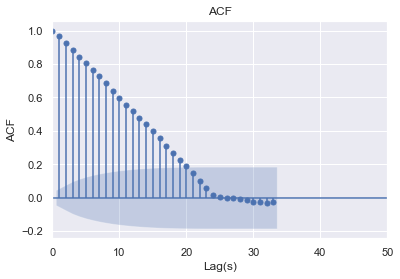

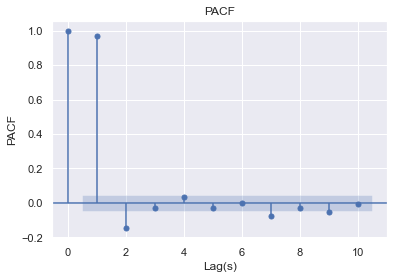

In [30]:
# Plotting ACF and PACF

# ACF
plot_acf(Y)
plt.title('ACF', loc='center')
plt.xlim((0, 50))
plt.ylabel('ACF')
plt.xlabel('Lag(s)')
plt.show()

# PACF
plot_pacf(Y, lags=10)
plt.title('PACF', loc='center')
plt.ylabel('PACF')
plt.xlabel('Lag(s)')
plt.show()

C:\Users\naman\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\naman\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H wil

                              ARMA Model Results                              
Dep. Variable:                    BTC   No. Observations:                 1500
Model:                     ARMA(1, 0)   Log Likelihood                 912.897
Method:                       css-mle   S.D. of innovations              0.132
Date:                Sun, 27 Mar 2022   AIC                          -1811.794
Time:                        15:37:02   BIC                          -1774.602
Sample:                    01-05-2022   HQIC                         -1797.939
                         - 03-08-2022                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0194      0.073     -0.266      0.791      -0.162       0.124
XMR              0.5354      0.032     16.776      0.000       0.473       0.598
gg_bitcoin_p    -0.0238      0.013     -1.76

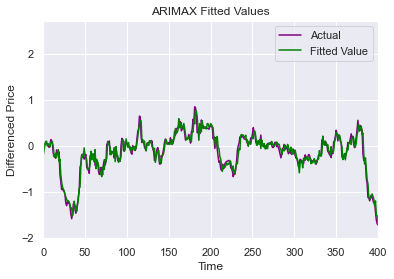

                          XMR  gg_bitcoin_p  gg_monero_p    gg_gpu
2022-03-08 12:00:00  0.180527     -0.138519    -0.061057  0.128581
2022-03-08 13:00:00  0.137357     -0.138519    -0.061057  0.128581
2022-03-08 14:00:00  0.376316     -0.138519    -0.061057  0.128581
2022-03-08 15:00:00  0.340559     -0.138519    -0.061057  0.128581
2022-03-08 16:00:00  0.486202     -0.138519    -0.061057  0.128581
...                       ...           ...          ...       ...
2022-03-23 20:00:00 -0.063664     -0.069259     0.488453 -0.450035
2022-03-23 21:00:00 -0.033576     -0.069259     0.488453 -0.450035
2022-03-23 22:00:00  0.033576     -0.069259     0.488453 -0.450035
2022-03-23 23:00:00  0.176602     -0.069259     0.488453 -0.450035
2022-03-24 00:00:00  0.136485      0.138519    -0.610566  0.835779

[373 rows x 4 columns]


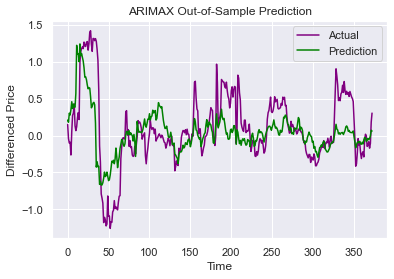

In [31]:
# ARIMAX

# Building AR 2 with exogeneous variables
arima_d = ARIMA.ARIMA(endog=Y_train['BTC'], exog=X_train, order=[1,0,0])
arima_results_d = arima_d.fit()
print(arima_results_d.summary())

# Plotting the fitted values
plt.plot(np.arange(len(Y_train)), Y_train, color='purple', label='Actual')
plt.plot(np.arange(len(arima_results_d.fittedvalues)), arima_results_d.fittedvalues, color='green', label='Fitted Value')
plt.xlim((0, 400))
plt.title('ARIMAX Fitted Values')
plt.xlabel('Time')
plt.ylabel('Differenced Price')
plt.legend()
plt.show()
print(X_test)

# Out-of-sample prediction
exog_d = X_test
arima_results_ofs_d = arima_results_d.predict(exog=exog_d, start=exog_d.index[0], end=exog_d.index[-1])
plt.plot(np.arange(len(Y_test)), Y_test, color='purple', label='Actual')
plt.plot(np.arange(len(arima_results_ofs_d)), arima_results_ofs_d, color='green', label='Prediction')
#plt.xlim((0, 50))
plt.title('ARIMAX Out-of-Sample Prediction')
plt.xlabel('Time')
plt.ylabel('Differenced Price')
plt.legend()
plt.show()

In [33]:
# Metric

# Calculating mean squared error for steps 1-100
expected = Y_test[:99]
predictions = arima_results_ofs_d[:99]
mse = mean_squared_error(expected, predictions)
print('Mean Squared Error')
print('Steps 1-100: %f' % mse)

# Calculating mean squred error for steps 101-373
expected = Y_test[100:]
predictions = arima_results_ofs_d[100:]
mse = mean_squared_error(expected, predictions)
print('Steps 101-373: %f' % mse)

Mean Squared Error
Steps 1-100: 0.315797
Steps 101-373: 0.084473
